In [36]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import urbanpy as up
import xycmap

In [37]:
# Read a geopackage file
gdf_population = gpd.read_file(filename="inputs/kontur_population_MA_20220630.gpkg", layer="population", driver="GPKG")
gdf_population.to_crs(epsg=4326, inplace=True)

In [38]:
# Read a geojson file
gdf_seismic_levels_part_1 = gpd.read_file(
    filename="inputs/20230908_SeismicIntensityZonesM6-8EQ_USGSpart1.geojson", driver="GeoJSON"
)
gdf_seismic_levels_part_2 = gpd.read_file(
    filename="inputs/20230908_SeismicIntensityZonesM6-8EQ_USGSpart2.geojson", driver="GeoJSON"
)
gdf_seismic_levels = gpd.GeoDataFrame(
    pd.concat([gdf_seismic_levels_part_1, gdf_seismic_levels_part_2], ignore_index=True)
)

In [39]:
gdf_population.head()

,h3,population,geometry
0,8855aab2ebfffff,4.0,"POLYGON ((-16.99504 21.36706, -16.99971 21.364..."
1,8855aab2c5fffff,1.0,"POLYGON ((-16.99040 21.37462, -16.99507 21.372..."
2,8855aab2a5fffff,4.0,"POLYGON ((-17.01833 21.34406, -17.02300 21.341..."
3,8855aab059fffff,1.0,"POLYGON ((-17.02316 21.36614, -17.02783 21.363..."
4,8855aab019fffff,5.0,"POLYGON ((-17.02770 21.34375, -17.03237 21.341..."


<Axes: >

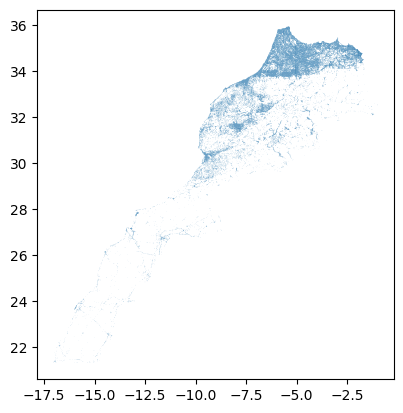

In [40]:
gdf_population.plot()

In [41]:
gdf_seismic_levels.head()

,FID,FID_mi,AREA,PERIMETER,PGAPOL_,PGAPOL_ID,GRID_CODE,PARAMVALUE,FID_BNDA_C,ISO3CD,...,MAPLAB,CONTCD,STSCOD,TYP005,TYP025,DEL025,ISOADM,Shape_STAr,Shape_STLe,geometry
0,0,0,0,0,13,13,0,2.6,145,MAR,...,Morocco,AFR,1,0,0,0,MAR,39.470259,40.517416,"MULTIPOLYGON (((-10.03885 28.99167, -10.03951 ..."
1,1,1,0,0,14,14,0,2.8,145,MAR,...,Morocco,AFR,1,0,0,0,MAR,39.470259,40.517416,"MULTIPOLYGON (((-5.65749 33.00749, -5.65573 33..."
2,2,2,0,0,15,15,0,3.0,145,MAR,...,Morocco,AFR,1,0,0,0,MAR,39.470259,40.517416,"MULTIPOLYGON (((-5.45833 33.16645, -5.45825 33..."
3,3,3,0,0,16,16,0,3.2,71,DZA,...,Algeria,AFR,1,0,0,0,DZA,212.622536,76.413260,"MULTIPOLYGON (((-5.82513 29.60954, -5.82516 29..."
4,4,3,0,0,16,16,0,3.2,145,MAR,...,Morocco,AFR,1,0,0,0,MAR,39.470259,40.517416,"MULTIPOLYGON (((-5.45833 33.57421, -5.45812 33..."


In [42]:
gdf_seismic_levels.shape

(36, 21)

In [43]:
gdf_seismic_levels.columns

Index(['FID', 'FID_mi', 'AREA', 'PERIMETER', 'PGAPOL_', 'PGAPOL_ID',
       'GRID_CODE', 'PARAMVALUE', 'FID_BNDA_C', 'ISO3CD', 'ROMNAM', 'MAPLAB',
       'CONTCD', 'STSCOD', 'TYP005', 'TYP025', 'DEL025', 'ISOADM',
       'Shape_STAr', 'Shape_STLe', 'geometry'],
      dtype='object')

In [44]:
# Define the class breaks information
class_breaks = [
    (0.0, 1.9999, "I (Not Felt)"),
    (2.0, 3.9999, "II - III (Weak)"),
    (4.0, 4.9999, "IV (Light)"),
    (5.0, 5.9999, "V (Moderate)"),
    (6.0, 6.9999, "VI (Strong)"),
    (7.0, 7.9999, "VII (Very Strong)"),
    (8.0, 8.9999, "VIII (Severe)"),
    (9.0, 9.9999, "IX (Violent)"),
    (10.0, 12.0, "X+ (Extreme)"),
]

# Create a DataFrame for the class breaks information
df_class_breaks = pd.DataFrame(class_breaks, columns=["Min_Value", "Max_Value", "Label"])

# Use pandas.cut to categorize values
bins = [df_class_breaks["Min_Value"].min()] + df_class_breaks["Max_Value"].tolist()
seismic_labels = df_class_breaks["Label"].tolist()

# Categorize the data
gdf_seismic_levels["Intensity"] = pd.cut(gdf_seismic_levels["PARAMVALUE"], bins=bins, labels=seismic_labels)

(count    36.000000
 mean      5.200000
 std       1.746834
 min       2.600000
 25%       3.750000
 50%       4.900000
 75%       6.650000
 max       8.400000
 Name: PARAMVALUE, dtype: float64,
 <Axes: >)

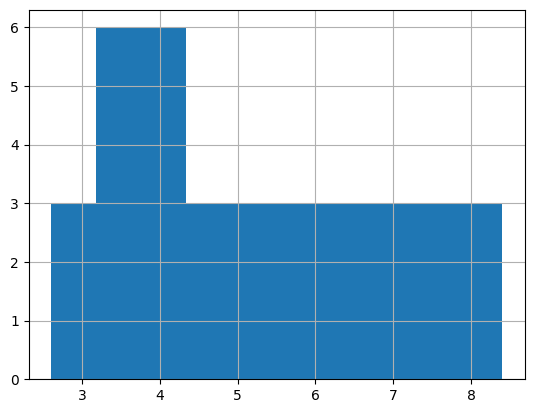

In [45]:
gdf_seismic_levels["PARAMVALUE"].describe(), gdf_seismic_levels["PARAMVALUE"].hist(bins=10)

<Axes: ylabel='Intensity'>

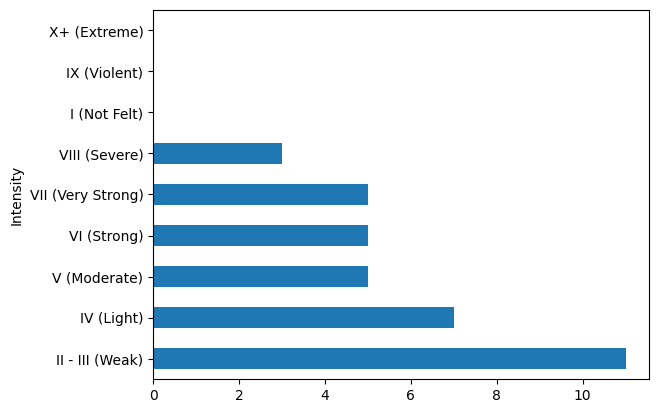

In [46]:
gdf_seismic_levels["Intensity"].value_counts().plot(kind="barh")

/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

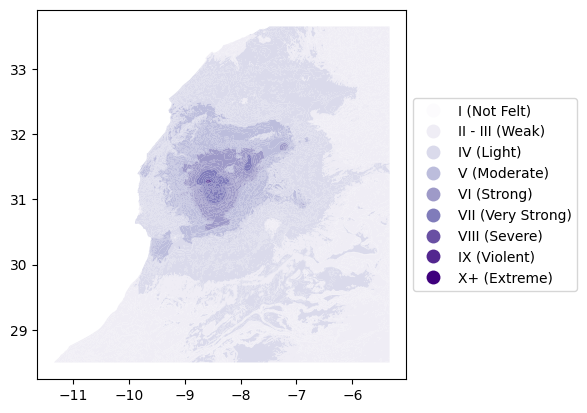

In [47]:
gdf_seismic_levels.plot(
    "Intensity",
    legend=True,
    cmap="Purples",
    linewidth=0,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1.0, 0.5)},
)

In [48]:
minx, miny, maxx, maxy = gdf_seismic_levels.total_bounds
gdf_population_clipped = gdf_population.cx[minx:maxx, miny:maxy]

/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

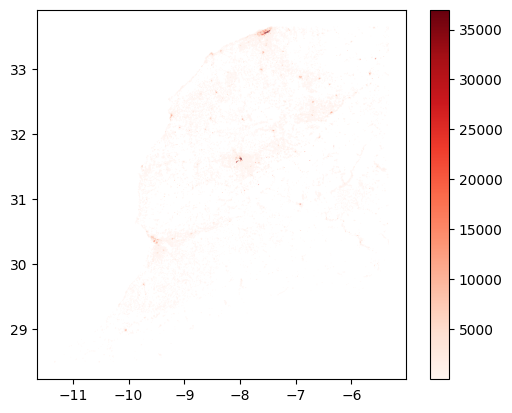

In [49]:
gdf_population_clipped.plot("population", legend=True, cmap="Reds", linewidth=0)

In [50]:
gdf_seismic_levels_hexagons = []
gdf_seismic_levels_parts = []
for intensity_level in gdf_seismic_levels["Intensity"].unique():
    roi = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(gdf_seismic_levels[gdf_seismic_levels["Intensity"] == intensity_level].unary_union),
        crs=gdf_seismic_levels.crs,
    )
    roi["Intensity"] = intensity_level
    gdf_seismic_levels_parts.append(roi)

    roi_hexs = up.geom.gen_hexagons(city=roi, resolution=8)
    roi_hexs["Intensity"] = intensity_level
    gdf_seismic_levels_hexagons.append(roi_hexs)

In [51]:
gdf_seismic_levels_parts = pd.concat(gdf_seismic_levels_parts, ignore_index=True)

In [52]:
gdf_seismic_levels_hexagons = pd.concat(gdf_seismic_levels_hexagons, ignore_index=True)

/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

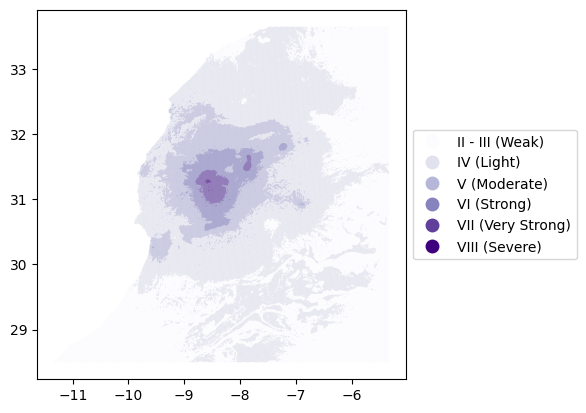

In [53]:
gdf_seismic_levels_hexagons.plot(
    "Intensity",
    legend=True,
    cmap="Purples",
    linewidth=0,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1.0, 0.5)},
)

In [54]:
gdf_seismic_levels_hexagons.head()

,hex,geometry,Intensity
0,88399bc419fffff,"POLYGON ((-7.24566 28.52000, -7.25069 28.51777...",II - III (Weak)
1,8839ab6e87fffff,"POLYGON ((-6.01403 33.13066, -6.01932 33.12856...",II - III (Weak)
2,8839985301fffff,"POLYGON ((-8.30081 28.98239, -8.30588 28.98011...",II - III (Weak)
3,88398a15d1fffff,"POLYGON ((-6.16629 30.73038, -6.17144 30.72823...",II - III (Weak)
4,88398acc8bfffff,"POLYGON ((-6.53195 30.52905, -6.53708 30.52688...",II - III (Weak)


In [55]:
gdf_population_clipped.head()

,h3,population,geometry
1917,88399069edfffff,1.0,"POLYGON ((-11.02740 28.75946, -11.03249 28.757..."
1918,8839906933fffff,1.0,"POLYGON ((-11.03280 28.75198, -11.03789 28.749..."
1919,8839906921fffff,1.0,"POLYGON ((-11.06777 28.74531, -11.07285 28.742..."
1967,883992aa63fffff,594.0,"POLYGON ((-11.33399 28.50044, -11.33906 28.498..."
1971,883992aa0dfffff,232.0,"POLYGON ((-11.32862 28.50794, -11.33369 28.505..."


In [68]:
gdf_population_seismic_levels = gdf_population_clipped.merge(
    gdf_seismic_levels_hexagons[["hex", "Intensity"]], how="left", left_on="h3", right_on="hex"
).drop("hex", axis=1)

In [69]:
# Categorize the population data
bins = [0] + [1000, 5000, 10000, 20000, 50000]
labels = [f"{bins[i]:.0f} - {bins[i+1]:.0f}" for i in range(len(bins) - 1)]

gdf_population_seismic_levels["population_class"] = pd.cut(
    gdf_population_seismic_levels["population"], bins=bins, labels=labels
)

In [70]:
xcmap = plt.cm.Reds
ycmap = plt.cm.Blues
cmap = xycmap.mean_xycmap(xcmap=xcmap, ycmap=ycmap, n=(len(labels), len(seismic_labels)))

In [71]:
sy = pd.Categorical(gdf_population_seismic_levels["Intensity"], categories=seismic_labels, ordered=True)
sx = pd.Categorical(gdf_population_seismic_levels["population_class"], categories=labels, ordered=True)

colors = xycmap.bivariate_color(
    sy=sy,
    sx=sx,
    cmap=cmap,
)

/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/xycmap/xycmap.py:107: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  x_categorical = types.is_categorical_dtype(sx)
/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/xycmap/xycmap.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  y_categorical = types.is_categorical_dtype(sy)


In [86]:
gdf_population_seismic_levels["colors"] = colors
gdf_population_seismic_levels_downsample = up.geom.resolution_downsampling(
    gdf_population_seismic_levels, hex_col="h3", coarse_resolution=5, agg={"colors": "max"}
)

/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/xycmap/xycmap.py:237: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  x_categorical = types.is_categorical_dtype(sx)
/Users/claudio/Documents/humanitarian-map-morocco/.env/lib/python3.11/site-packages/xycmap/xycmap.py:238: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  y_categorical = types.is_categorical_dtype(sy)


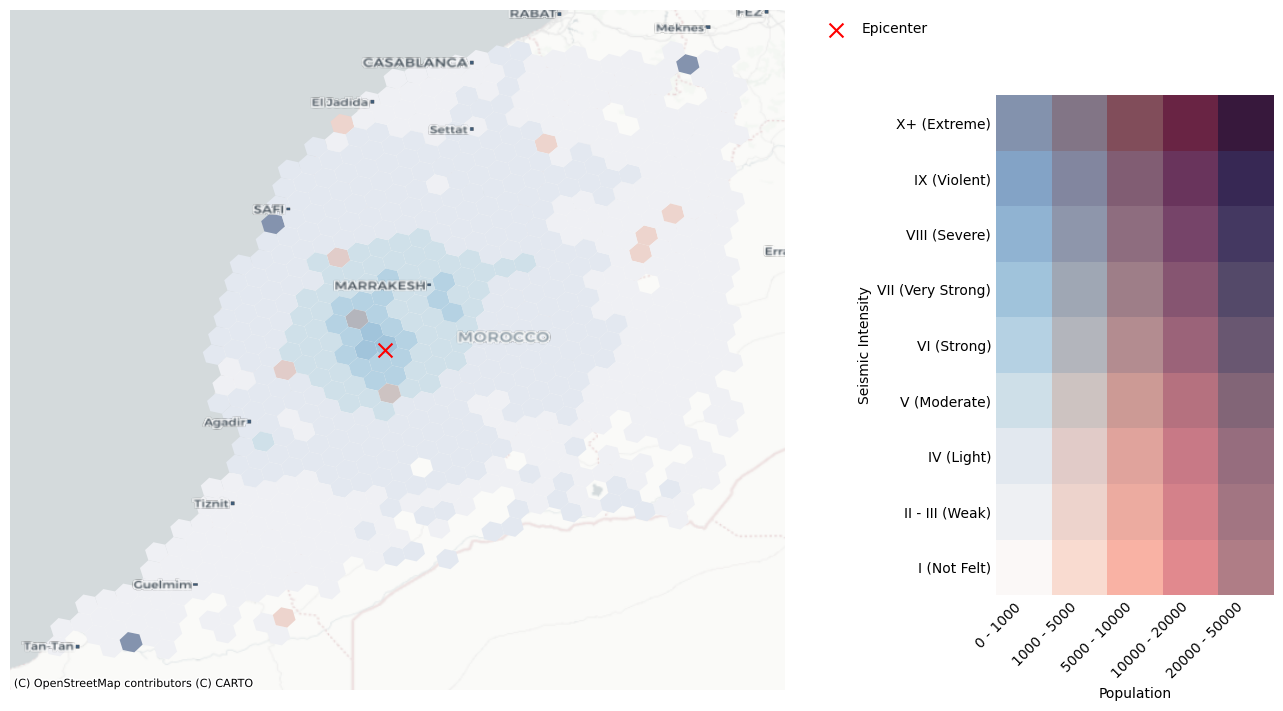

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))

cax = fig.add_axes([1, 0.25, 0.5, 0.5])
cax = xycmap.bivariate_legend(ax=cax, sx=sx, sy=sy, cmap=cmap)
cax.set(frame_on=False)
cax.set_xticklabels(labels, rotation=45, ha="right")
cax.tick_params(axis="both", which="both", length=0)
cax.set_xlabel("Population")
cax.set_ylabel("Seismic Intensity")

# gdf_population_seismic_levels.plot(color=colors, linewidth=0, ax=ax)
gdf_population_seismic_levels_downsample.plot(color=gdf_population_seismic_levels_downsample["colors"], ax=ax)
# Plor point X: -8.390999999999963 Y: 31.064000000000078 as epicenter
ax.scatter(-8.390999999999963, 31.064000000000078, s=100, c="red", marker="x", label="Epicenter")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1), frameon=False)

ax.set_axis_off()
ctx.add_basemap(ax, crs=gdf_population_seismic_levels.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
ctx.add_basemap(ax, crs=gdf_population_seismic_levels.crs.to_string(), source=ctx.providers.CartoDB.PositronOnlyLabels)

plt.savefig("outputs/humanitarianMapMorocco.png", dpi=300, bbox_inches="tight")

In [77]:
# Save hexagons to csv without geometry column, because the h3 index contains the geometry information already and it saves space
gdf_population_seismic_levels.drop("geometry", axis=1).to_csv(
    "outputs/morocco_population_seismic_levels.csv", index=False
)

In [78]:
gdf_seismic_levels_parts["Intensity"] = gdf_seismic_levels_parts["Intensity"].astype(str)
gdf_seismic_levels_parts.to_file("outputs/morocco_seismic_levels.geojson", driver="GeoJSON")